In [11]:
import mysql.connector
import pandas as pd
import numpy as np
import time

user = 'mariadb'
password = 'mariadb'
database_name = 'mariadb'
host = 'db'
port = 3308

cnx = mysql.connector.connect(user='mariadb', password='mariadb',
                              host="localhost",
                              database=database_name,
                              port='3308')

# cursor = cnx.cursor()
# cnx.close()

querry = "SELECT date, adj_close FROM stocks WHERE type_id = 56;"
df = pd.read_sql(querry,cnx)
df['date'] = df['date'].apply(lambda x: np.datetime64(time.strftime( '%Y-%m-%d', time.gmtime(x))))
# df.set_index('date', inplace=True)

print(df.head)


<bound method NDFrame.head of            date   adj_close
0    2024-03-12  203.205933
1    2024-03-13  202.179993
2    2024-03-14  199.729996
3    2024-03-15  200.199997
4    2024-03-18  201.199997
...         ...         ...
2519 2024-03-21  206.050003
2520 2024-03-22  203.509995
2521 2024-03-25  202.339996
2522 2024-03-26  201.710007
2523 2024-03-19  202.250000

[2524 rows x 2 columns]>


/tmp/ipykernel_11991/1081196957.py:21: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(querry,cnx)


<Axes: xlabel='adj_close', ylabel='date'>

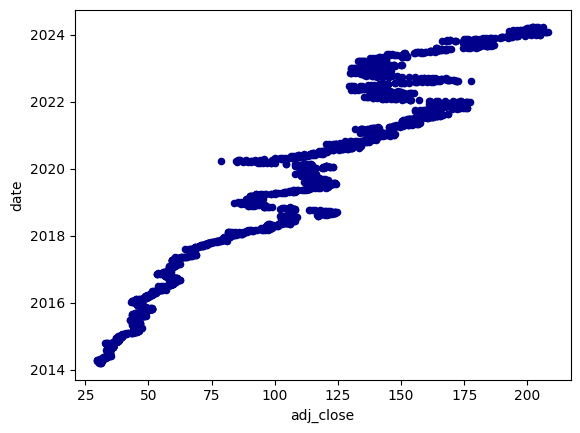

In [12]:
df.plot.scatter(x='adj_close',y='date',c='DarkBlue')